# Energy Data Preparation

In [1]:
rm(list=ls())

In [2]:
library(fs)
library(stringr)
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [3]:
# Read files and select columns
folder = getwd()

file_list <- dir_ls(file.path(dirname(folder), "data/energy_production/raw"), regexp = "\\.csv$")
df <- data.frame()

for (i in seq_along(file_list)) {
    file <- file_list[i]
    
    if (i == length(file_list)) {
        tmp <- read.csv(file, sep = ";")
        } 
    else {
            tmp <- read.csv(file, sep = ",")
        }
    tmp <- select(tmp, "MTU", "Wind.Offshore....Actual.Aggregated..MW.",
                     "Wind.Onshore....Actual.Aggregated..MW.")
    df <- rbind(df, tmp)
}

colnames(df) <- c("date", "w_offshore", "w_onshore")

# Remove rows with "-" 
df <- df[!grepl("-", df$w_offshore), ]
df <- df[!grepl("-", df$w_onshore), ]
 
# Fill missing data with 0 (solar time change and no production)
df$w_offshore <- as.numeric(ifelse(df$w_offshore == "n/e", 0, df$w_offshore))
df$w_onshore <- as.numeric(ifelse(df$w_onshore == "n/e", 0, df$w_onshore))
df[is.na(df)] <- 0
# Aggregate by date (there are duplicates)
df <- aggregate(df[,2:3], by=list(df$date), FUN=sum)

# Aggregate wind production OnShore and OffShore
df$wind_prod <- df$w_offshore + df$w_onshore
df$w_offshore <- NULL
df$w_onshore <- NULL
colnames(df) <- c("date", "wind_prod")

# Fix column date
date_tmp<-str_sub(df$date, 1, 10)
date_tmp<-gsub("\\." , "/", date_tmp)
date_tmp<-as.Date(date_tmp, format = "%d/%m/%Y")
df$date<-date_tmp

# Aggregate by day -> median value
df<-aggregate(df["wind_prod"], by=list(df$date), FUN=mean)
colnames(df) <- c("date", "wind_prod")

df <- df %>%
    filter(date <= "2023-09-02")

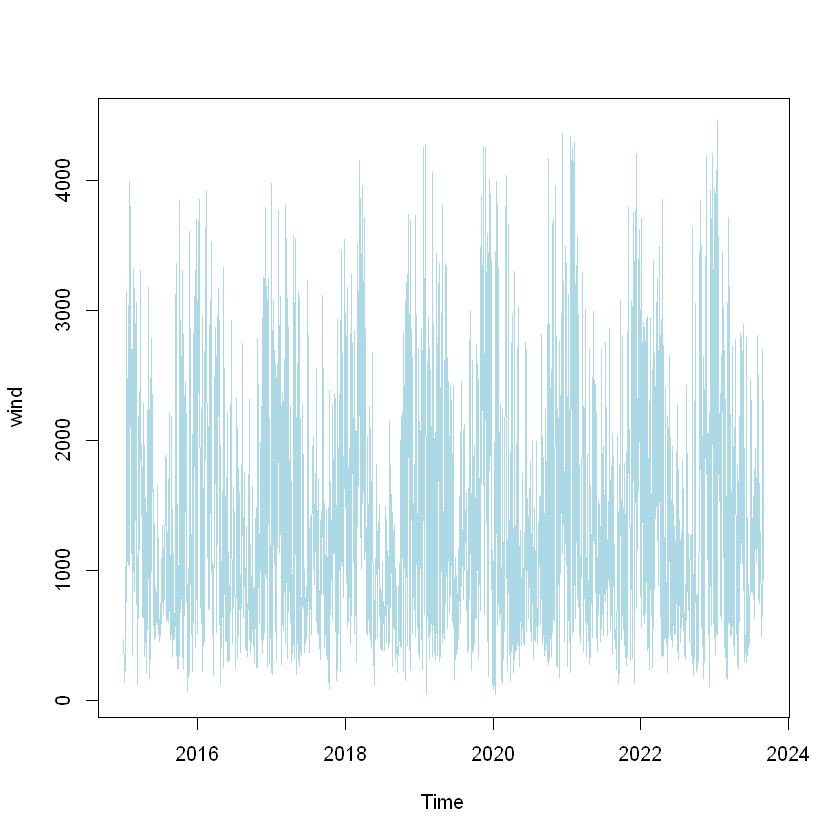

In [4]:
# Timer series plot
wind<-ts(df$wind_prod, frequency = 365.25, start=c(2015, 01, 01))
ts.plot(wind, col=c("lightblue"))

In [5]:
# Save the file 
write.csv(df, file=file.path(dirname(folder), "data/energy_production/final/wind_production.csv"), row.names = FALSE)